# Stock Data Pipeline


## 0. Install Zipline

You will need to restart your runtime after installing since zipline uses an older version of pandas.

In [3]:
!pip3 install zipline==1.3.0
!pip3 install alphalens

## 1. Load libraries data directories

In [1]:
import zipline
import alphalens as al

from collections import OrderedDict
import numpy as np

import pandas as pd
import statsmodels.api as sm
from os import listdir
import pickle
import sys

import os

from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.data.data_portal import DataPortal
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import CustomFactor, DailyReturns, AverageDollarVolume, Returns, RSI, AnnualizedVolatility


from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.assets._assets import Equity
from zipline.api import symbol

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Zipline root directory
zipline_dir = '/content/drive/MyDrive/abnormal-distribution-project-data/zipline'

os.environ['ZIPLINE_ROOT'] = zipline_dir

## 2. Ingestion and raw data processing 

### 2.1 Ingestion and Data Processing functions

In [4]:
# Portions of this code adapted from https://github.com/pbharrin/alpha-compiler


METADATA_HEADERS = ['start_date', 'end_date', 'auto_close_date',
                    'symbol', 'exchange', 'asset_name']


def check_for_abnormal_returns(df, thresh=3.0):
    """Checks to see if any days have abnormal returns"""
    returns = df['close'].pct_change()
    abnormal_rets = returns[returns > thresh]
    if abnormal_rets.shape[0] > 0:
        sys.stderr.write('Abnormal returns for: {}\n'.format(df.ix[0]['ticker']))
        sys.stderr.write('{}\n'.format(str(abnormal_rets)))


def from_sep_dump(file_name, start=None, end=None):
    """
    Function that reads full Sharadar stock price csv file
    sharadar_sep.csv, and returns an ingest function for Zipline

    """
    us_calendar = get_calendar("NYSE").all_sessions
    ticker2sid_map = {}

    def ingest(environ,
               asset_db_writer,
               minute_bar_writer,  # unused
               daily_bar_writer,
               adjustment_writer,
               calendar,
               cache,
               show_progress,
               output_dir,
               # pass these as defaults to make them 'nonlocal' in py2
               start=start,
               end=end):

        print("starting ingesting data from: {}".format(file_name))

        # read in the whole dump (will require ~7GB of RAM)
        df = pd.read_csv(file_name, index_col='date',
                         parse_dates=['date'], na_values=['NA'])

        # drop unused columns, dividends will be used later
        df = df.drop(['lastupdated', 'dividends', 'closeunadj'], axis=1)

        # counter of valid securites, this will be our primary key
        sec_counter = 0
        data_list = []  # list to send to daily_bar_writer
        metadata_list = []  # list to send to asset_db_writer (metadata)

        # iterate over all the unique securities and pack data, and metadata
        # for writing
        for tkr, df_tkr in df.groupby('ticker'):
            df_tkr = df_tkr.sort_index()

            row0 = df_tkr.ix[0]  # get metadata from row

            print(" preparing {}".format(row0["ticker"]))
            check_for_abnormal_returns(df_tkr)

            # check to see if there are missing dates in the middle
            this_cal = us_calendar[(us_calendar >= df_tkr.index[0]) & (us_calendar <= df_tkr.index[-1])]
            if len(this_cal) != df_tkr.shape[0]:
                print('MISSING interstitial dates for: %s using forward fill' % row0["ticker"])
                print('number of dates missing: {}'.format(len(this_cal) - df_tkr.shape[0]))
                df_desired = pd.DataFrame(index=this_cal.tz_localize(None))
                df_desired = df_desired.join(df_tkr)
                df_tkr = df_desired.fillna(method='ffill')

            # update metadata; 'start_date', 'end_date', 'auto_close_date',
            # 'symbol', 'exchange', 'asset_name'
            metadata_list.append((df_tkr.index[0],
                                  df_tkr.index[-1],
                                  df_tkr.index[-1] + pd.Timedelta(days=1),
                                  row0["ticker"],
                                  "SEP",  # all have exchange = SEP
                                  row0["ticker"]  # TODO: can we delete this?
                                  )
                                 )

            # drop metadata columns
            df_tkr = df_tkr.drop(['ticker'], axis=1)

            # pack data to be written by daily_bar_writer
            data_list.append((sec_counter, df_tkr))
            ticker2sid_map[tkr] = sec_counter  # record the sid for use later
            sec_counter += 1

        print("writing data for {} securities".format(len(metadata_list)))
        daily_bar_writer.write(data_list, show_progress=False)

        # write metadata
        asset_db_writer.write(equities=pd.DataFrame(metadata_list,
                                                    columns=METADATA_HEADERS))
        print("a total of {} securities were loaded into this bundle".format(
            sec_counter))

        # read in Dividend History
        dfd = pd.read_csv(file_name, index_col='date',
                         parse_dates=['date'], na_values=['NA'])
        # drop rows where dividends == 0.0
        dfd = dfd[dfd["dividends"] != 0.0]
        dfd = dfd.dropna()

        dfd.loc[:, 'ex_date'] = dfd.loc[:, 'record_date'] = dfd.index
        dfd.loc[:, 'declared_date'] = dfd.loc[:, 'pay_date'] = dfd.index
        dfd.loc[:, 'sid'] = dfd.loc[:, 'ticker'].apply(lambda x: ticker2sid_map[x])
        dfd = dfd.rename(columns={'dividends': 'amount'})
        dfd = dfd.drop(['open', 'high', 'low', 'close', 'volume', 'lastupdated', 'ticker', 'closeunadj'], axis=1)

        # # format dfd to have sid
        adjustment_writer.write(dividends=dfd)

    return ingest

def get_tickers_from_bundle(bundle_name):
    """Gets a list of tickers from a given bundle"""
    bundle_data = bundles.load(bundle_name, os.environ, None)

    # get a list of all sids
    lifetimes = bundle_data.asset_finder._compute_asset_lifetimes()
    all_sids = lifetimes.sid

    # retreive all assets in the bundle
    all_assets = bundle_data.asset_finder.retrieve_all(all_sids)

    # return only tickers
    return map(lambda x: (x.symbol, x.sid), all_assets)


def get_all_assets_for_bundle(bundle_name):
    """For a given bundle get a list of all assets"""
    bundle_data = load(bundle_name, os.environ, None)

    # get a list of all sids
    lifetimes = bundle_data.asset_finder._compute_asset_lifetimes()
    all_sids = lifetimes.sid

    print('all_sids: ', all_sids)

    # retreive all assets in the bundle
    return bundle_data.asset_finder.retrieve_all(sids=all_sids)


def get_ticker_sid_dict_from_bundle(bundle_name):
    """Packs the (ticker,sid) tuples into a dict."""
    all_equities = get_tickers_from_bundle(bundle_name)
    return dict(all_equities)

def pack_sparse_data(N, rawpath, fields, filename):
    """pack data into np.recarray and persists it to a file to be
    used by SparseDataFactor"""


    # create buffer to hold data for all tickers
    dfs = [None] * N

    max_len = -1
    print("Packing sids")
    for fn in listdir(rawpath):
        if not fn.endswith(".csv"):
            continue
        df = pd.read_csv(os.path.join(rawpath,fn), index_col="Date", parse_dates=True)
        df = df.sort_index()
        sid = int(fn.split('.')[0])
        #print("packing sid: %d" % sid)
        dfs[sid] = df

        # width is max number of rows in any file
        max_len = max(max_len, df.shape[0])
    print("Finished packing sids")

    # temp workaround for `Array Index Out of Bound` bug
    max_len = max_len + 1

    # pack up data as buffer
    num_fundamentals = len(fields)
    buff = np.full((num_fundamentals + 1, N, max_len), np.nan)

    dtypes = [('date', '<f8')]
    for field in fields:
        dtypes.append((field, '<f8'))

    # pack self.data as np.recarray
    data = np.recarray(shape=(N, max_len), buf=buff, dtype=dtypes)

    # iterate over loaded data and populate self.data
    for i, df in enumerate(dfs):
        if df is None:
            continue
        ind_len = df.index.shape[0]
        data.date[i, :ind_len] = df.index
        for field in fields:
            data[field][i, :ind_len] = df[field]

    data.dump(filename)  # can be read back with np.load()


def load_sf1(sf1_dir, 
             fields, 
             bund ='sep', 
             npy_name='SF1', 
             stocks_dir = '/content/drive/MyDrive/abnormal-distribution-project-data/stocks/dummy',
             dimensions=None):
    """
    Loads SF1 data into a npy compressed file SF1.npy
    :param sf1_dir: Sharadar SF1 bulk file
    :param fields: fields to load
    :param dimensions: dimensions to load. One-to-one with fields. If None, assume ARQ if data available,
    ART if not
    """

    bundles.register(bund, from_sep_dump('.', '.'), )
    num_tickers = len(get_ticker_sid_dict_from_bundle(bund))
    print('number of tickers: ', num_tickers)

    data = pd.read_csv(sf1_dir)

    tickers = get_ticker_sid_dict_from_bundle(bund)
    
    counter = 0
    for ticker, sid in tickers.items():
        counter += 1
        if counter % 100 == 0:
            print("Working on {}-th file".format(counter))

        df = data[(data.ticker == ticker)]
        df = df.rename(columns={'datekey': 'Date'}).set_index('Date')
        df.index = df.index.rename('Date')
        series = []
        for i, field in enumerate(fields):
            if dimensions is None:
                if df[df.dimension == 'ARQ'][field].isna().sum() == df[df.dimension == 'ARQ'].shape[0]:
                    s = df[df.dimension == 'ART'][field]
                else:
                    s = df[df.dimension == 'ARQ'][field]
            else:
                s = df[df.dimension == dimensions[i]][field]
            series.append(s)

        df = pd.concat(series, axis=1)
        df = df.sort_index()
        df.index = df.index.rename('Date')
        df.to_csv(os.path.join(stocks_dir, "{}.csv".format(sid)))
    
    pack_sparse_data(num_tickers + 1,  # number of tickers in bundle + 1
                     stocks_dir,
                     fields,
                     zipline_dir + '/data/' + npy_name +  '.npy')  # write directly to the zipline data dir

SECTOR_CODING = {'Technology': 0,
                 'Industrials': 1,
                 'Energy': 2,
                 'Utilities': 3,
                 'Consumer Cyclical': 4,
                 'Healthcare': 5,
                 'Financial Services': 6,
                 'Basic Materials': 7,
                 'Consumer Defensive': 8,
                 'Real Estate': 9,
                 'Communication Services': 10,
                 np.nan: -1}  # a few tickers are missing sectors, these should be ignored

EXCHANGE_CODING = {'NYSE': 0,
                   'NASDAQ': 1,
                   'NYSEMKT': 2,  # previously AMEX
                   'OTC': 3,
                   'NYSEARCA': 4,
                   'BATS': 5}


def load_static(filepath):
    """Stores static items to a persisted np array.
    The following static fields are currently persisted.
    -Sector
    -exchange
    -industry: GICS
    """
    bundles.register('sep', int, )

    df = pd.read_csv(filepath, index_col="ticker")
    df = df[df.exchange != 'None']
    df = df[df.exchange != 'INDEX']
    df = df[df.table == 'SEP']

    coded_sectors_for_ticker = df['sector'].map(SECTOR_CODING)
    coded_exchange_for_ticker = df['exchange'].map(EXCHANGE_CODING)
    coded_industry_for_ticker = df['siccode'].fillna(-1).astype('int')

    ae_d = get_ticker_sid_dict_from_bundle('sep')
    N = max(ae_d.values()) + 1

    # create 2-D array to hold data where index = SID
    static_data = np.full((3, N), -1, np.dtype('int64'))

    # iterate over Assets in the bundle, and fill in static fields
    print('Creating static data')
    for ticker, sid in ae_d.items():
        #print(ticker, sid, coded_sectors_for_ticker.get(ticker, -1))
        static_data[0, sid] = coded_sectors_for_ticker.get(ticker, -1)
        static_data[1, sid] = coded_exchange_for_ticker.get(ticker, -1)
        static_data[2, sid] = coded_industry_for_ticker.get(ticker, -1)
    print('Finished creating static data')

    # finally save the file to disk
    np.save(zipline_dir + '/data/' + "SHARDAR_static.npy", static_data)


class SparseDataFactor(CustomFactor):
    """Abstract Base Class to be used for computing sparse data.
    The data is packed and persisted into a NumPy binary data file
    in a previous step.
    This class must be subclassed with class variable 'outputs' set.  The fields
    in 'outputs' should match those persisted."""
    inputs = []
    window_length = 1

    def __init__(self, *args, **kwargs):
        self.time_index = None
        self.curr_date = None # date for which time_index is accurate
        self.data = None
        self.data_path = "please_specify_.npy_file"

    def bs(self, arr):
        """Binary Search"""
        if len(arr) == 1:
            if self.curr_date < arr[0]:
                return 0
            else: return 1

        mid = int(len(arr) / 2)
        if self.curr_date < arr[mid]:
            return self.bs(arr[:mid])
        else:
            return mid + self.bs(arr[mid:])

    def bs_sparse_time(self, sid):
        """For each security find the best range in the sparse data."""
        dates_for_sid = self.data.date[sid]
        if np.isnan(dates_for_sid[0]):
            return 0

        # do a binary search of the dates array finding the index
        # where self.curr_date will lie.
        non_nan_dates = dates_for_sid[~np.isnan(dates_for_sid)]
        return self.bs(non_nan_dates) - 1

    def cold_start(self, today, assets):
        if self.data is None:
            self.data = np.load(self.data_path, allow_pickle=True)

        self.M = self.data.date.shape[1]

        # for each sid, do binary search of date array to find current index
        # the results can be shared across all factors that inherit from SparseDataFactor
        # this sets an array of ints: time_index
        self.time_index = np.full(self.N, -1, np.dtype('int64'))
        self.curr_date = today.value
        for asset in assets:  # asset is numpy.int64
            self.time_index[asset] = self.bs_sparse_time(asset)

    def update_time_index(self, today, assets):
        """Ratchet update.
        for each asset check if today >= dates[self.time_index]
        if so then increment self.time_index[asset.sid] += 1"""

        ind_p1 = self.time_index.copy()
        np.add.at(ind_p1, ind_p1 != (self.M - 1), 1)
        sids_to_increment = today.value >= self.data.date[np.arange(self.N), ind_p1]
        sids_not_max = self.time_index != (self.M - 1)   # create mask of non-maxed
        self.time_index[sids_to_increment & sids_not_max] += 1

        self.curr_date = today.value

    def compute(self, today, assets, out, *arrays):
        # for each asset in assets determine index from date (today)
        if self.time_index is None:
            self.cold_start(today, assets)
        else:
            self.update_time_index(today, assets)

        ti_used_today = self.time_index[assets]

        for field in self.__class__.outputs:
            out[field][:] = self.data[field][assets, ti_used_today]


class Fundamentals(SparseDataFactor):
    outputs = ['marketcap', 'assets', 'liabilities', 'pe', 'currentratio', 'netmargin', 'capex', 'fcf', 'roic']
    window_safe = True

    def __init__(self, *args, **kwargs):
        super(Fundamentals, self).__init__(*args, **kwargs)
        self.N = len(get_ticker_sid_dict_from_bundle("sep")) + 1  # max(sid)+1 get this from the bundle
        self.data_path = zipline_dir + '/data/' + 'SF1.npy'

class FundamentalsSP500(SparseDataFactor):
    outputs = ['marketcap', 'assets', 'liabilities', 'pe', 'currentratio', 'netmargin', 'capex', 'fcf', 'roic']
    window_safe = True

    def __init__(self, *args, **kwargs):
        super(FundamentalsSP500, self).__init__(*args, **kwargs)
        self.N = len(get_ticker_sid_dict_from_bundle("sp500")) + 1  # max(sid)+1 get this from the bundle
        self.data_path = zipline_dir + '/data/' + 'SF1_SP500.npy'

class FundamentalsSP1500(SparseDataFactor):
    outputs = ['marketcap', 'assets', 'liabilities', 'pe', 'currentratio', 'netmargin', 'capex', 'fcf', 'roic']
    window_safe = True

    def __init__(self, *args, **kwargs):
        super(FundamentalsSP1500, self).__init__(*args, **kwargs)
        self.N = len(get_ticker_sid_dict_from_bundle("sp1500")) + 1  # max(sid)+1 get this from the bundle
        self.data_path = zipline_dir + '/data/' + 'SF1_SP1500.npy'

class StaticData(CustomFactor):
    """Returns static values for an SID.
    This holds static data (does not change with time) like: exchange, sector, industry"""
    inputs = []
    window_length = 1
    window_safe = True
    outputs = ['sector', 'exchange', 'industry']

    def __init__(self, *args, **kwargs):
        self.data = np.load(zipline_dir + '/data/' + 'SHARDAR_static.npy', allow_pickle=True)

    def compute(self, today, assets, out):
        # out[:] = self.data[assets]
        out['sector'][:] = self.data[0, assets]
        out['exchange'][:] = self.data[1, assets]
        out['industry'][:] = self.data[2, assets]

### 2.2 Ingest stock and fundamental data into Zipine

Warning: Running this code will overwrite database and can take almost an hour to run!

In [5]:
# Stock price data ingestion

#!zipline ingest -b 'sep'
#zipline ingest -b 'sp500'
#!zipline ingest -b 'sp1500'

In [6]:
# Fundamental data ingestion

# Choose which fundamental fields you want to be able to process through the pipeline.
# A list of  of all available fields can be found below.

# Fundamental data directory
#sf1_dir = '/content/drive/MyDrive/abnormal-distribution-project-data/stocks/SHARADAR_SF1.csv'
#fields = ['marketcap', 'assets', 'liabilities', 'pe', 'currentratio', 'netmargin', 'capex', 'fcf', 'roic']
#load_sf1(sf1_dir, fields, dimensions=None)


In [7]:
# Static data ingestions
#static_file = '/content/drive/MyDrive/abnormal-distribution-project-data/stocks/SHARADAR_TICKERS.zip'
#load_static(static_file)

An explanation of database related fields can be found in :

  https://www.quandl.com/databases/SF1/documentation?anchor=dimensions

A summary of each fundamental field can be found in:

https://docs-1-8--quantrocket.netlify.app/docs/data/fundamental/sharadar/
        
        ['ticker', 'dimension', 'calendardate', 'datekey', 'reportperiod',
       'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc',
       'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor',
       'consolinc', 'currentratio', 'de', 'debt', 'debtc', 'debtnc', 'debtusd',
       'deferredrev', 'depamor', 'deposits', 'divyield', 'dps', 'ebit',
       'ebitda', 'ebitdamargin', 'ebitdausd', 'ebitusd', 'ebt', 'eps',
       'epsdil', 'epsusd', 'equity', 'equityavg', 'equityusd', 'ev', 'evebit',
       'evebitda', 'fcf', 'fcfps', 'fxusd', 'gp', 'grossmargin']

       ['intexp', 'invcap', 'invcapavg', 'inventory', 'investments',
       'investmentsc', 'investmentsnc', 'liabilities', 'liabilitiesc',
       'liabilitiesnc', 'marketcap', 'ncf', 'ncfbus', 'ncfcommon', 'ncfdebt',
       'ncfdiv', 'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc',
       'netinccmn', 'netinccmnusd', 'netincdis', 'netincnci', 'netmargin',
       'opex', 'opinc', 'payables', 'payoutratio', 'pb', 'pe', 'pe1',
       'ppnenet', 'prefdivis', 'price', 'ps', 'ps1', 'receivables', 'retearn',
       'revenue', 'revenueusd', 'rnd', 'roa', 'roe', 'roic', 'ros', 'sbcomp',
       'sgna', 'sharefactor', 'sharesbas', 'shareswa', 'shareswadil', 'sps',
       'tangibles', 'taxassets', 'taxexp', 'taxliabilities', 'tbvps',
       'workingcapital']

# 3. Equity factors

## 3.1 Load helper functions

In [8]:
# Portions of these code adapted from https://www.udacity.com/course/ai-for-trading--nd880 


def register_data(start_date, end_date, bundle_name, address):

    start_session = pd.Timestamp(start_date, tz='utc')
    end_session = pd.Timestamp(end_date, tz='utc')

    register(bundle_name, csvdir_equities(['daily'],address,),
    calendar_name='NYSE', start_session=start_session,
    end_session=end_session)


class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader)

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader

def build_pipeline_engine(bundle_data, trading_calendar):
    pricing_loader = PricingLoader(bundle_data)

    engine = SimplePipelineEngine(
        get_loader=pricing_loader.get_loader,
        calendar=trading_calendar.all_sessions,
        asset_finder=bundle_data.asset_finder)

    return engine

# Loading stock list from file
def stock_list(file_name):
    all_stocks = []
    with open(file_name, 'r') as f:
        for line in f:
            # remove linebreak which is the last character of the string
            currentPlace = line[:-1]
            # add item to the list
            all_stocks.append(currentPlace)
        return all_stocks

def get_universe_tickers(engine, universe, end_date):
    universe_end_date = pd.Timestamp(end_date, tz='UTC')

    universe_tickers = engine \
        .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date) \
        .index.get_level_values(1) \
        .values.tolist()

    return universe_tickers


def get_pricing(assets, bundle_data, start_date, end_date, field='close'):

    # Select trading calendar
    trading_calendar = get_calendar('NYSE')
    # Initialize data portal
    data_portal = DataPortal(bundle_data.asset_finder,
                             trading_calendar=trading_calendar,
                             first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
                             equity_minute_reader=None,
                             equity_daily_reader=bundle_data.equity_daily_bar_reader,
                             adjustment_reader=bundle_data.adjustment_reader)

    return _get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field=field)


def _get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):

    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(assets=assets,
                                          end_dt=end_dt,
                                          bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')


def run_pipeline(engine, pipeline, start_date, end_date):

    # TODO: adjust for trading days
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC')
    return engine.run_pipeline(pipeline, start_dt, end_dt)


def get_pipeline_tickers(factors):

    return factors.index.levels[1].values.tolist()


def make_pipeline(factors, universe):
    factors_pipe = OrderedDict()
        
    for name, f in factors.items():
        factors_pipe[name] = f
                    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

def print_stats(data_df, shift=0, periods=1, bins=2):

    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing.shift(shift), periods=[periods], max_loss=0.96, bins=bins, quantiles=None)
        for factor, factor_data in pd.DataFrame(data_df).iteritems()}

    unixt_factor_data = {
        factor: factor_data.set_index(pd.MultiIndex.from_tuples(
            [(x.timestamp(), y) for x, y in factor_data.index.values],
            names=['date', 'asset']))
        for factor, factor_data in clean_factor_data.items()}

    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

    (1+ls_factor_returns).cumprod().plot()

    qr_factor_returns = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(4,2),
        figsize=(14, 14),
        legend=False);

    print("Sharpe ratio: ", (np.sqrt(252)*ls_factor_returns.mean()/ls_factor_returns.std()).values[0] ) 

    return (1+ls_factor_returns).cumprod()


def get_sharpe(data_df, shift=0, periods=1, bins=2):

    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing.shift(shift), periods=[periods], max_loss=0.96, bins=bins, quantiles=None)
        for factor, factor_data in pd.DataFrame(data_df).iteritems()}

    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

    return (np.sqrt(252)*ls_factor_returns.mean()/ls_factor_returns.std()).values[0] 

def get_tearsheets(data_df, shift=0, periods=1, bins=2):

    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing.shift(shift), periods=[periods], max_loss=0.96, bins=bins, quantiles=None)
        for factor, factor_data in pd.DataFrame(data_df).iteritems()}

    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.tears.create_full_tear_sheet(factor_data)

def get_pyfolio(data_df, shift=0, periods=1, bins=2,period='fb'):

    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing.shift(shift), periods=[periods], max_loss=0.96, bins=bins, quantiles=None)
        for factor, factor_data in pd.DataFrame(data_df).iteritems()}

    print(clean_factor_data)

    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

    return ls_factor_returns



    #return (np.sqrt(252)*ls_factor_returns.mean()/ls_factor_returns.std()).values[0] 

#pd.DataFrame(sorted([asset.security_name for asset in all_assets]), 
#             columns =['ticker']).to_csv('sp1500.csv', index=False)

#data = pd.read_csv('/content/drive/MyDrive/abnormal-distribution-project-data/stocks/SHARADAR_SEP.csv')
#sp500_tickers = pd.read_csv('/content/drive/MyDrive/abnormal-distribution-project-data/components/sp500.csv')
#data_sp500 = data[data.ticker.isin(sp500_tickers.ticker)]
#data_sp500.reset_index(inplace=True, drop=True)
#data_sp500.to_csv('/content/drive/MyDrive/abnormal-distribution-project-data/stocks/SHARADAR_SP500.csv', index=False)

## 3.2 Custom Factors


In [9]:
bundles.register('sp1500', from_sep_dump('.'))
universe = FundamentalsSP1500().marketcap.top(1500)
#adv = AverageDollarVolume(window_length=120)

class Residuals(CustomFactor):
    
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, 
                s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11,
                st1, st2, st3, st4, st5, 
                returns):
               
        #w = adv.reshape(-1,1)
        #w = np.nan_to_num(w.reshape(-1,1))
        #X = np.concatenate((s1, s2, s3, s4, s5, s6, s7, s8, s9, 
        #                    s10, s11, st1, st2, st3, st4, st5), axis=0).T
        #X = np.nan_to_num(sm.add_constant(X))
        #y = np.nan_to_num(returns.reshape(-1,1))     
        #model = sm.WLS(y, X, weights=w)
        
        X = np.concatenate((s1, s2, s3, s4, s5, s6, s7, s8, s9, 
                            s10, s11, st1, st2, st3, st4, st5), axis=0).T
        X = np.nan_to_num(sm.add_constant(X))
        y = np.nan_to_num(returns.reshape(-1,1))     
        model = sm.OLS(y, X)  

        out[:] = model.fit().resid


def make_returns():
    
    all_factors = {
        
        '1D_ret_open': DailyReturns(inputs=[USEquityPricing.open]),
        '1W_ret_open': Returns(inputs=[USEquityPricing.open], window_length=5),
        '1M_ret_open': Returns(inputs=[USEquityPricing.open], window_length=21), 
        '3M_ret_open': Returns(inputs=[USEquityPricing.open], window_length=63),
        '6M_ret_open': Returns(inputs=[USEquityPricing.open], window_length=126), 
        '1Y_ret_open': Returns(inputs=[USEquityPricing.open], window_length=252),
        
        '1D_ret_close': DailyReturns() ,
        '1W_ret_close': Returns(window_length=5),
        '1M_ret_close': Returns(window_length=21), 
        '3M_ret_close': Returns(window_length=63),
        '6M_ret_close': Returns(window_length=126),
        '1Y_ret_close': Returns(window_length=252),
    }
    
    return all_factors

def make_factors():

    def ForwardReturns(long_window, short_window, asset=None, mask=universe):
        if asset == None:
            return ((1 + Returns(window_length=long_window, mask=mask))/\
                    (1 + Returns(window_length=short_window, mask=mask)) - 1)
        else:
            return ((1 + Returns(inputs=[asset], window_length=long_window, mask=mask))/\
                    (1 + Returns(inputs=[asset], window_length=short_window, mask=mask)) - 1)
            
    class AverageMarketReturn(CustomFactor):
        inputs = [DailyReturns()]
        window_length = 1
        window_safe = True
        mask = universe

        def compute(self, today, assets, out, returns):
            # returns are days in rows, assets across columns
            out[:] = np.nanmean(returns)
            
            
    def Target():
        return DailyReturns(mask=universe).winsorize(0.1,0.9) # - AverageMarketReturn()
        
    def Momentum_style():
        return ForwardReturns(252,20).zscore()

    def Size_style(): 
        return FundamentalsSP1500().marketcap.log().zscore()

    class Value(CustomFactor):      
        inputs = [FundamentalsSP1500().marketcap, FundamentalsSP1500().assets, FundamentalsSP1500().liabilities] 
        window_length = 1
        window_safe = True
        mask = universe

        def compute(self, today, assets, out, market_cap, total_assets, total_liabilities):       
            out[:] = (total_assets[-1] - total_liabilities[-1]) / market_cap[-1]

    def Value_style():
        return Value(mask=universe).zscore()

    #def Reversal_style():    
    #    return -RSI(mask=universe).zscore()

    def Reversal_style():    
        return -Returns(window_length=5, mask=universe).zscore()

    def Volatility_style():   
        return AnnualizedVolatility(window_length=126, mask=universe).zscore()

    
    class SectorEncode(CustomFactor):
        inputs=[StaticData().sector]
        window_length=1
        window_safe=True

        params = ('sector',)
        def compute(self, today, assets, out, choices, sector):
            out[:] = 1 * (choices == sector)
            

            
    residual_inputs = [
                        SectorEncode(sector =0, mask=universe),
                        SectorEncode(sector =1, mask=universe),
                        SectorEncode(sector =2, mask=universe),
                        SectorEncode(sector =3, mask=universe),
                        SectorEncode(sector =4, mask=universe),
                        SectorEncode(sector =5, mask=universe),
                        SectorEncode(sector =6, mask=universe),
                        SectorEncode(sector =7, mask=universe),
                        SectorEncode(sector =8, mask=universe),
                        SectorEncode(sector =9, mask=universe),
                        SectorEncode(sector =10, mask=universe),
                        Momentum_style(),
                        Size_style(),
                        Value_style(),
                        Reversal_style(),
                        Volatility_style(),
                        Target(),
                       ]
    
    
    def ResidualVolatility(window_length=126):
        res = Residuals(inputs=residual_inputs, mask=universe)
        return AnnualizedVolatility(inputs=[res], window_length=window_length)
       
            
    all_factors ={
        
        'Momentum_style':Momentum_style(),
        'Size_style':Size_style(),
        'Value_style':Value_style(),
        'Reversal_style':Reversal_style(),
        'Volatility_style':Volatility_style(),
        'Sector':StaticData().sector,
        'Residuals':Residuals(inputs=residual_inputs),
        'Residual_volatility': ResidualVolatility(),
    }
        
    return all_factors
    

## 3.3 Run pipeline


In [10]:
# Obtain data, choose trading calendar and build pipeline engine

trading_calendar = get_calendar('NYSE') 
bundles.register('sp1500', from_sep_dump('.'))
bundle_data = bundles.load('sp1500')
engine = build_pipeline_engine(bundle_data, trading_calendar)

### Build calendar

In [11]:
# Set date range
start_date = '2010-12-30'
end_date = '2020-11-19'
universe_start_date = pd.Timestamp(start_date, tz='UTC')
universe_end_date = pd.Timestamp(end_date, tz='UTC')

# Select universe of stocks
universe = FundamentalsSP1500().marketcap.top(1500) 


In [ ]:
# Run pipeline 
all_factors = run_pipeline(engine, pipeline, universe_start_date, universe_end_date)
# Convert tickers from zipline class to string
all_factors.index = all_factors.index.set_levels(all_factors.index.levels[1].map(lambda x: x.asset_name), level=1)
# Get all tickers for the stocks we're looking at
all_assets = get_pipeline_tickers(all_factors)

In [ ]:
# Factors

pipeline = make_pipeline(make_factors(), universe)
all_factors = run_pipeline(engine, pipeline, universe_start_date, universe_end_date)
all_factors = pickle.load(open('/content/drive/MyDrive/abnormal-distribution-project-data/components/factors_sp1500.p','rb'))
all_factors.index = all_factors.index.set_levels(all_factors.index.levels[1].map(lambda x: x.asset_name), level=1)
all_factors = all_factors.ffill()
all_factors = all_factors.reset_index()
all_factors = all_factors.rename(columns={'level_0':'date','level_1':'ticker'})
all_factors.ticker = all_factors.ticker.str.lower()
all_factors.to_csv('/content/drive/MyDrive/abnormal-distribution-project-data/components/factors_sp1500.csv',index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:371: RuntimeWarning: invalid value encountered in less_equal


In [ ]:
# Returns

sp1500_returns = pickle.load(open('/content/drive/MyDrive/abnormal-distribution-project-data/components/returns_sp1500.p','rb'))
sp1500_returns[['1D_fwd_close', '1D_fwd_open']] = sp1500_returns[['1D_ret_close', '1D_ret_open']].groupby(level=1).shift(-1)
sp1500_returns[['1M_fwd_close', '1M_fwd_open']] = sp1500_returns[['1M_ret_close', '1M_ret_open']].groupby(level=1).shift(-20)
sp_cols = ['date','ticker','1D_ret_close', '1D_fwd_close', '1M_ret_close', '1M_fwd_close', 
                           '1D_ret_open', '1D_fwd_open', '1M_ret_open', '1M_fwd_open']
sp1500_returns = sp1500_returns.reset_index().rename(columns={'level_0':'date','level_1':'ticker'})[sp_cols]
sp1500_returns.ticker = sp1500_returns.ticker.apply(lambda x: x.asset_name)
sp1500_returns.date = sp1500_returns.date.dt.date
sp1500_returns.dropna(inplace=True)
sp1500_returns.to_csv('/content/drive/MyDrive/abnormal-distribution-project-data/components/returns_sp1500.csv',index=False)


## Estimate returns for different models

In [14]:
returns = pickle.load(open('/content/drive/MyDrive/abnormal-distribution-project-data/components/returns_sp1500.p','rb'))
scores = pd.read_csv('/content/drive/MyDrive/abnormal-distribution-project-data/lean/scores_master.csv')
our1 = pd.read_csv('/content/drive/MyDrive/abnormal-distribution-project-data/BERT_MODEL_6/predictions.csv')[['_id','pred']]
our1 = our1.rename(columns={'pred':'finbert_finetuned'})
#our2 = pd.read_csv('/content/drive/MyDrive/abnormal-distribution-project-data/BERT_MODEL_8/predictions.csv')[['_id','pred']]
#our2 = pred8.rename(columns={'pred':'pred8'})

scores = scores.merge(our1, on=['_id'], how='left')
#scores = scores.merge(our2, on=['_id'], how='left')

returns = returns[['1D_ret_close', '1D_ret_open']]
scores = scores.groupby(['close_date', 'ticker']).mean()[['dict_score',	'bert_baseline',	'finbert_baseline', 'finbert_finetuned']].reset_index()
scores.ticker = scores.ticker.str.upper()
scores['close_date'] = pd.to_datetime(scores['close_date'], utc=True)
ticker_sid_dict = get_ticker_sid_dict_from_bundle('sp1500')
scores.ticker = bundle_data.asset_finder.retrieve_all(scores.ticker.apply(lambda x:ticker_sid_dict[x]))

scores = scores.groupby(['close_date', 'ticker']).mean()
idx = scores.index.intersection(returns.index)
returns = returns.loc[idx]
scores = scores.loc[idx]
scores = returns.merge(scores,left_index=True, right_index=True)

In [16]:
assets = scores.index.levels[1].values.tolist()
pricing = get_pricing(assets, bundle_data, universe_start_date, universe_end_date, field='close')

### FinBERT Fine tuned

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.4884052483962975
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  8.3411742306842
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed 

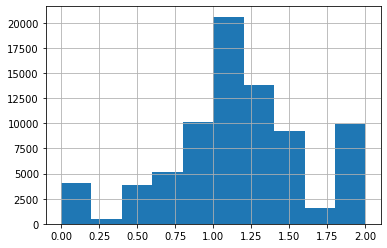

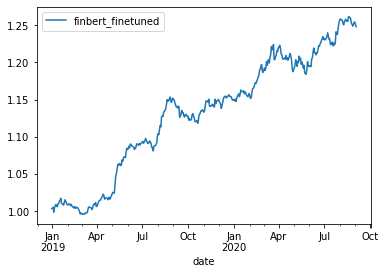

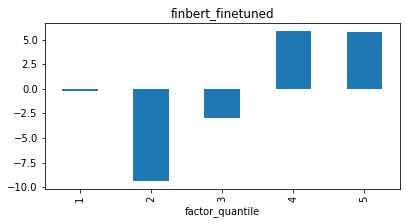

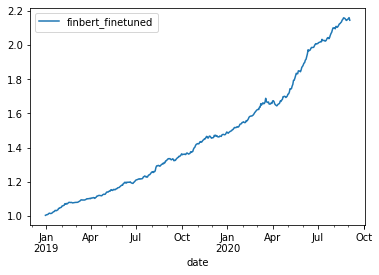

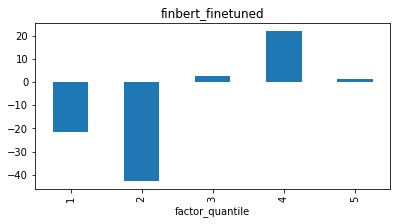

In [17]:
score_analysis = scores['finbert_finetuned'].dropna()[scores.finbert_finetuned!=1]
score_analysis.hist()
returns_tom_finetuned = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_tod_finetuned = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_finetuned = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_finetuned.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))

### Loughran-McDonald

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  1.7568165494959382
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  10.910377816652732
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppress

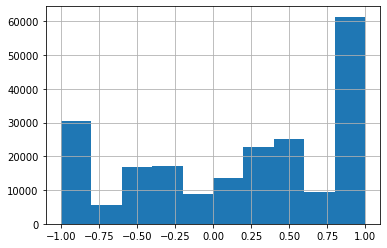

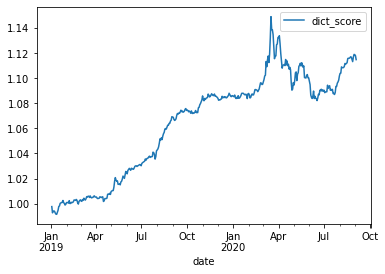

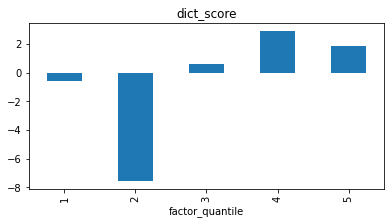

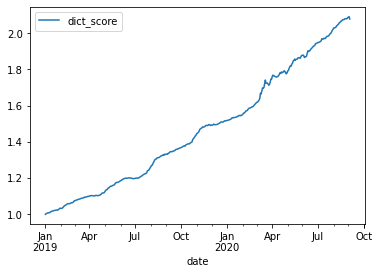

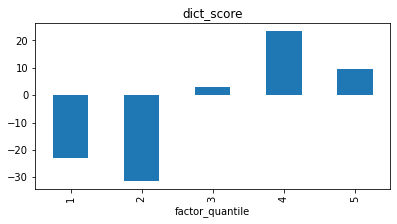

In [18]:
score_analysis = scores['dict_score']['2019-01-02':][scores.dict_score!=0]
score_analysis.hist()
returns_tom_dict = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_tod_dict = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_dict = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_dict.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))

### Bert baseline

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  1.619386967109813
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  7.759423809481128
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed

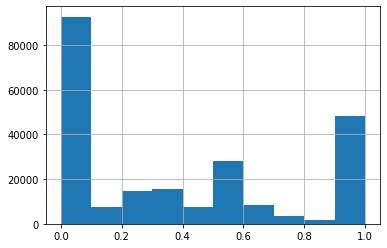

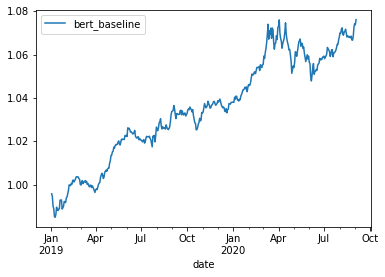

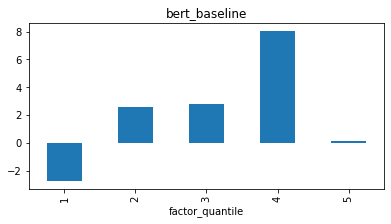

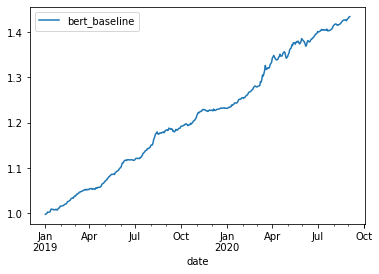

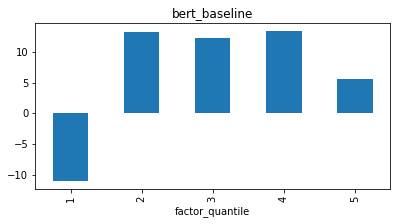

In [19]:
score_analysis= scores['bert_baseline']['2019-01-02':].dropna()
score_analysis.hist()
returns_tom_bert = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_tod_bert = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_bert = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_bert.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))



### Finbert Baseline

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  3.083231805620087
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  15.943029779919703
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppresse

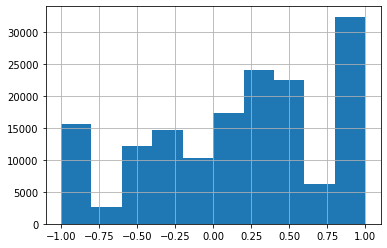

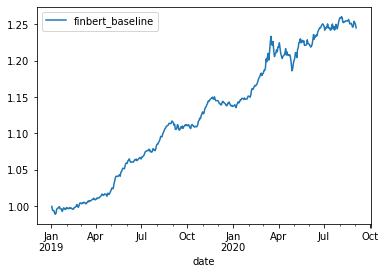

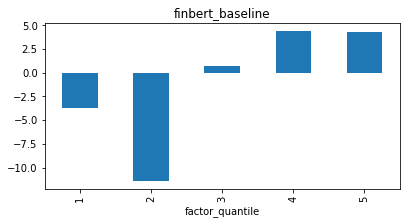

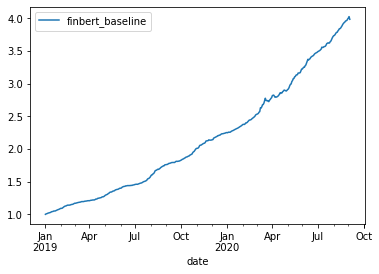

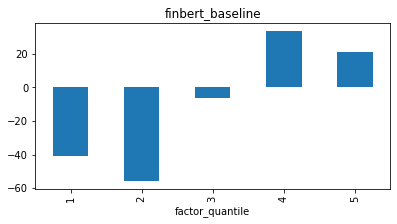

In [20]:
score_analysis = scores['finbert_baseline']['2019-01-02':].dropna()[scores.finbert_baseline!=0]
score_analysis.hist()
returns_tom_finbert = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_tod_finbert = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_finbert = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_finbert.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))


### Ensemble

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.404805480118212
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  12.84019129738452
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed

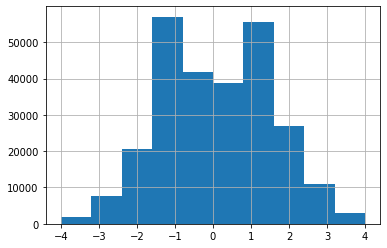

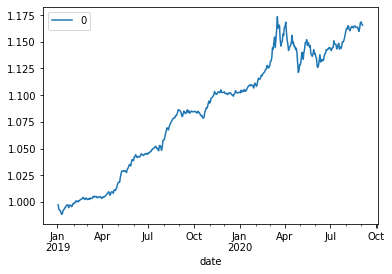

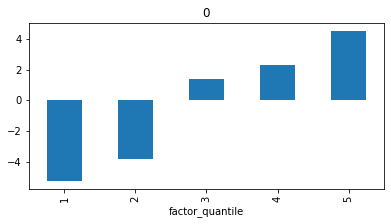

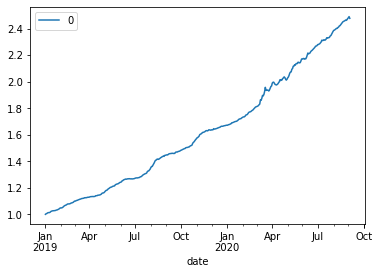

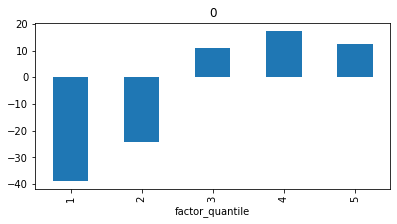

In [31]:
base_adjust = 2 * scores['bert_baseline'] - 1
base_adjust[base_adjust.isna()]=0
finetuned_adjust = scores['finbert_finetuned'] - 1
scc =  scores['finbert_baseline']  + finetuned_adjust + scores['dict_score']  + base_adjust 
scc = scc[scc!=0]
score_analysis = scc['2019-01-02':]
score_analysis.hist()
returns_tom_ensemble = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_tod_ensemble = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_ensemble = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_ensemble.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))


### Aggregate plots

In [33]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

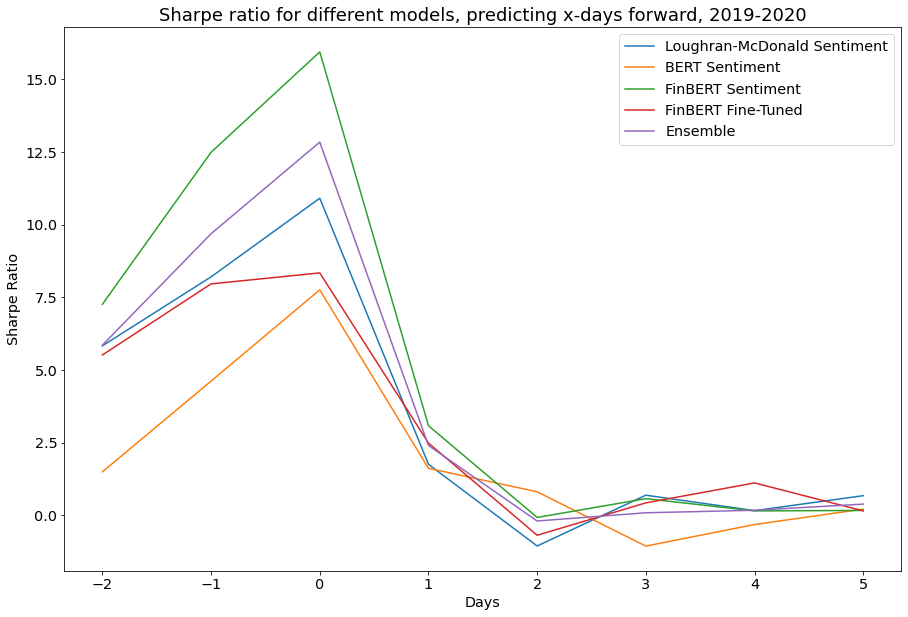

In [80]:
plt.subplots(figsize=(15,10))
plt.plot(-np.array([3, 2, 1,0,-1,-2,-3,-4])+1, sharpes_dict, label='Loughran-McDonald Sentiment')
plt.plot(-np.array([3, 2, 1,0,-1,-2,-3,-4])+1, sharpes_bert, label='BERT Sentiment')
plt.plot(-np.array([3, 2, 1,0,-1,-2,-3,-4])+1, sharpes_finbert, label='FinBERT Sentiment')
plt.plot(-np.array([3, 2, 1,0,-1,-2,-3,-4])+1, sharpes_finetuned, label='FinBERT Fine-Tuned')
plt.plot(-np.array([3, 2, 1,0,-1,-2,-3,-4])+1, sharpes_ensemble, label='Ensemble')
plt.title('Sharpe ratio for different models, predicting x-days forward, 2019-2020', fontsize=18)
plt.xlabel('Days')
plt.ylabel('Sharpe Ratio')
plt.legend();

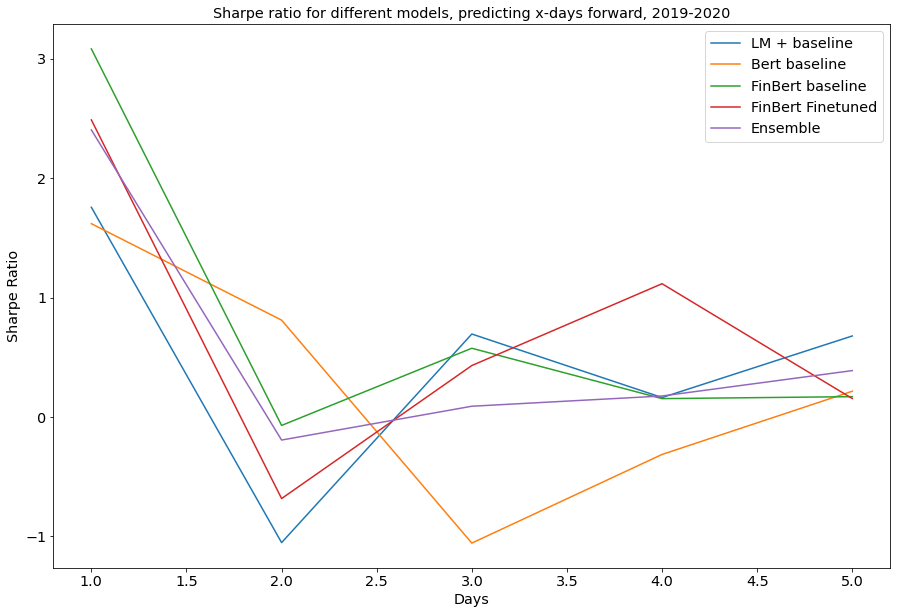

In [44]:
plt.subplots(figsize=(15,10))
plt.plot(-np.array([0,-1,-2,-3,-4])+1, sharpes_dict[3:], label='LM + baseline')
plt.plot(-np.array([0,-1,-2,-3,-4])+1, sharpes_bert[3:], label='Bert baseline')
plt.plot(-np.array([0,-1,-2,-3,-4])+1, sharpes_finbert[3:], label='FinBert baseline')
plt.plot(-np.array([0,-1,-2,-3,-4])+1, sharpes_finetuned[3:], label='FinBert Finetuned')
plt.plot(-np.array([0,-1,-2,-3,-4])+1, sharpes_ensemble[3:], label='Ensemble')
plt.title('Sharpe ratio for different models, predicting x-days forward, 2019-2020')
plt.xlabel('Days')
plt.ylabel('Sharpe Ratio')
plt.legend();

In [ ]:
ret_plot_pd = pd.DataFrame(index = returns_tom_finbert.index)

ret_plot_pd['finbert baseline'] = returns_tom_finbert
ret_plot_pd['bert baseline'] = returns_tom_bert
ret_plot_pd['dictionary baseline'] = returns_tom_dict
ret_plot_pd['finbert finetuned'] = returns_tom_finetuned
ret_plot_pd['ensemble'] = returns_tom_ensemble



Text(0, 0.5, 'Return')

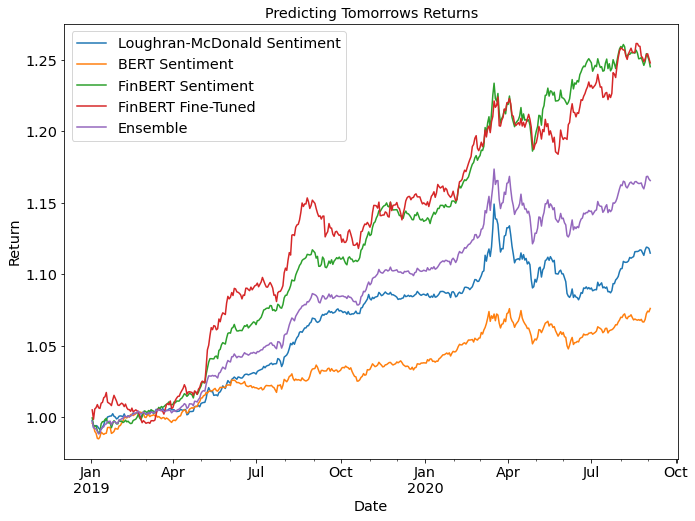

In [81]:
ret_plot_pd = pd.DataFrame(index = returns_tom_finbert.index)

ret_plot_pd['Loughran-McDonald Sentiment'] = returns_tom_dict
ret_plot_pd['BERT Sentiment'] = returns_tom_bert
ret_plot_pd['FinBERT Sentiment'] = returns_tom_finbert
ret_plot_pd['FinBERT Fine-Tuned'] = returns_tom_finetuned
ret_plot_pd['Ensemble'] = returns_tom_ensemble

x = ret_plot_pd.plot(title='Predicting Tomorrows Returns',figsize=(11,8))
x.set_xlabel('Date')
x.set_ylabel('Return')


Text(0, 0.5, 'Return')

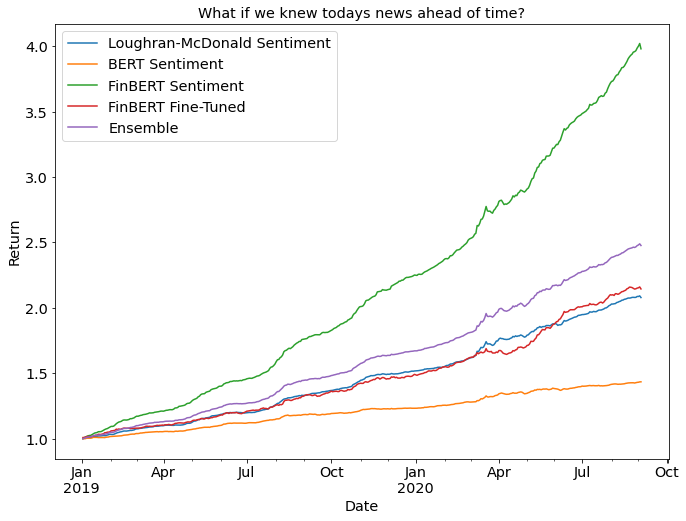

In [82]:
ret_plot_pd = pd.DataFrame(index = returns_tod_finbert.index)

ret_plot_pd['Loughran-McDonald Sentiment'] = returns_tod_dict
ret_plot_pd['BERT Sentiment'] = returns_tod_bert
ret_plot_pd['FinBERT Sentiment'] = returns_tod_finbert
ret_plot_pd['FinBERT Fine-Tuned'] = returns_tod_finetuned
ret_plot_pd['Ensemble'] = returns_tod_ensemble

x = ret_plot_pd.plot(title='What if we knew todays news ahead of time?',figsize=(11,8));
x.set_xlabel('Date')
x.set_ylabel('Return')

### Split by market cap

In [60]:
factors = pickle.load(open('/content/drive/MyDrive/abnormal-distribution-project-data/components/factors_sp1500.p','rb'))
scores_with_factors = scores.reset_index().merge(factors.reset_index(), on=['level_1','level_0']).set_index(['level_0','level_1'])

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.6827724488333273
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  14.139817580575443
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppress

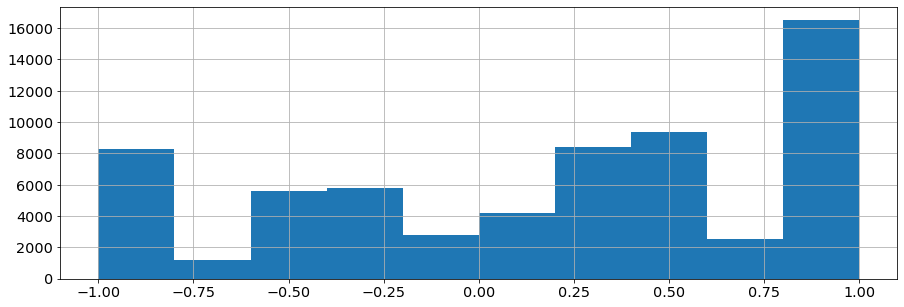

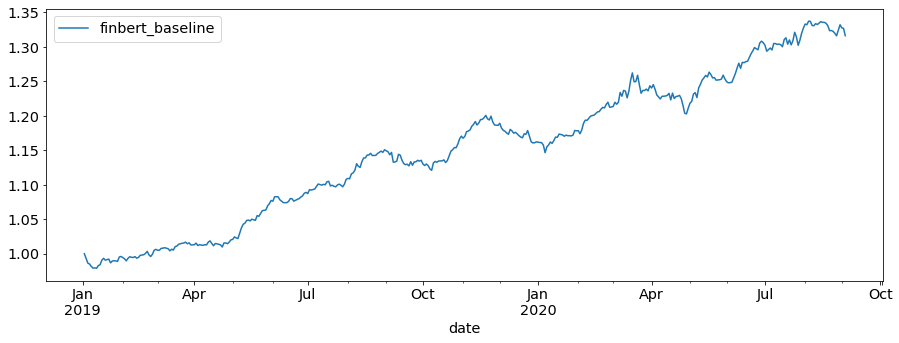

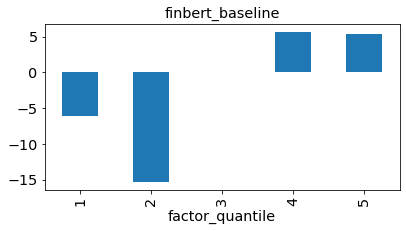

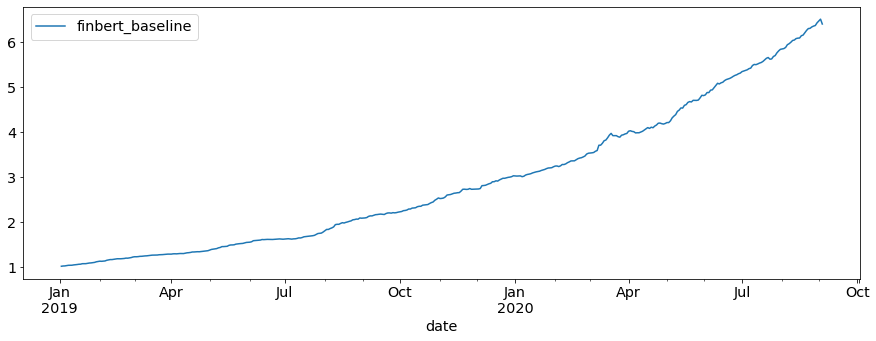

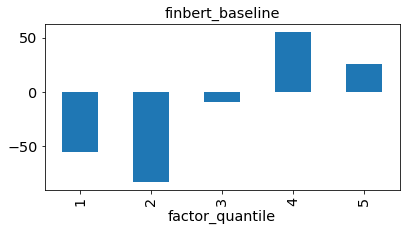

In [64]:
small_scores = scores_with_factors[scores_with_factors.Size_style<0][['dict_score',	'bert_baseline',	'finbert_baseline']]
score_analysis = small_scores['finbert_baseline'].dropna()[small_scores.finbert_baseline!=0]['2019-01-02':]
score_analysis.hist()
returns_finbert_small_tom = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_finbert_small_tod = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_finbert_small = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_finbert_small.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))



Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.4391643315749163
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  12.327730891872367
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppress

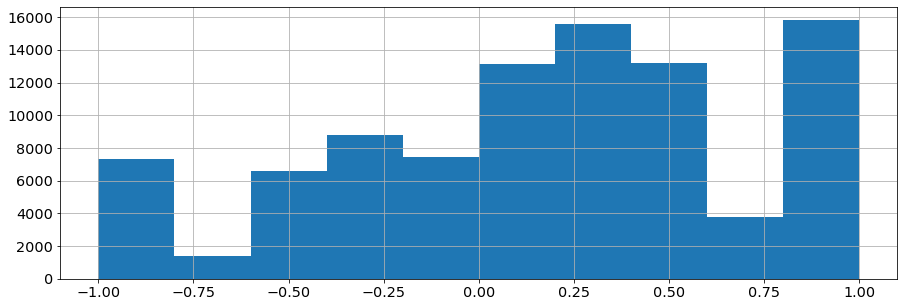

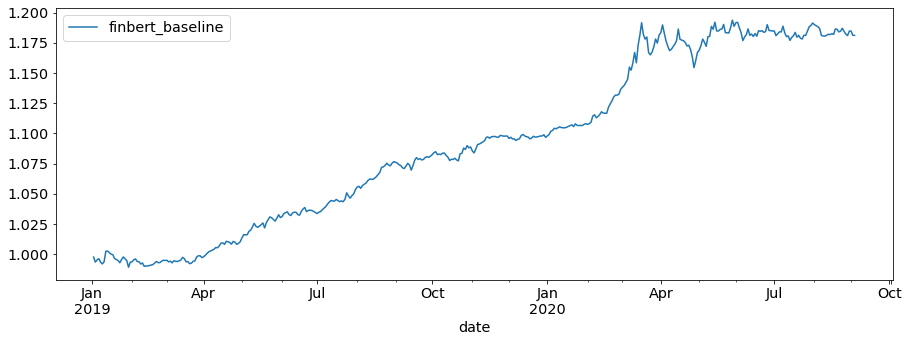

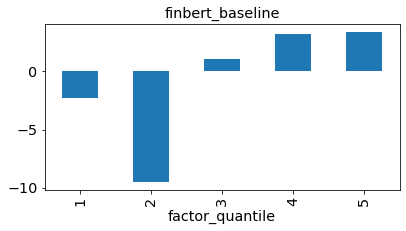

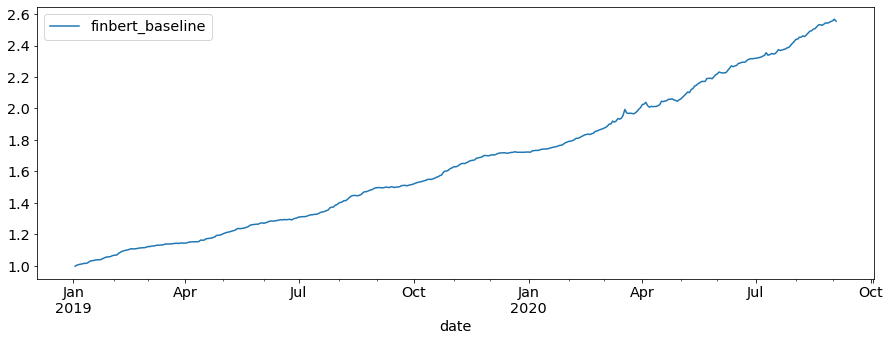

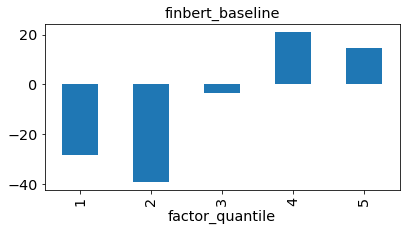

In [65]:
big_scores = scores_with_factors[scores_with_factors.Size_style>0][['dict_score',	'bert_baseline',	'finbert_baseline']]
score_analysis = big_scores['finbert_baseline'].dropna()[big_scores.finbert_baseline!=0]['2019-01-02':]
score_analysis.hist()
returns_finbert_big_tom = print_stats(score_analysis, shift=0, periods=1, bins=5)
returns_finbert_big_tod = print_stats(score_analysis, shift=1, periods=1, bins=5)
sharpes_finbert_big = []
for sh in [3, 2, 1,0,-1,-2,-3,-4]:
  sharpes_finbert_big.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))

Text(0, 0.5, 'Return')

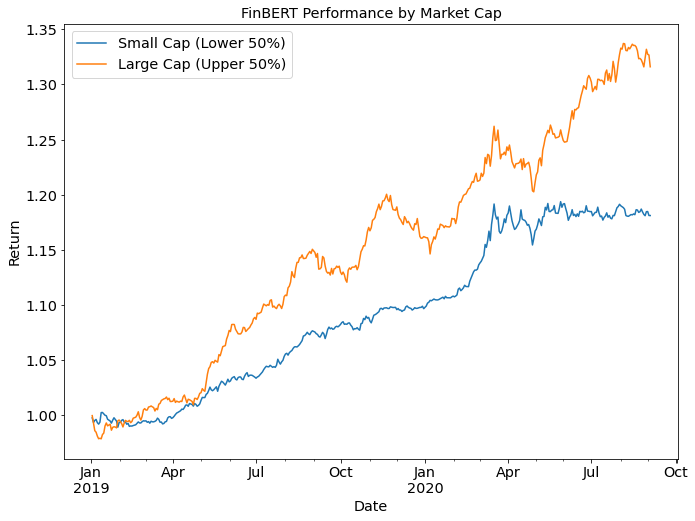

In [83]:
ret_plot_pd = pd.DataFrame(index = returns_tom_finbert.index)

ret_plot_pd['Small Cap (Lower 50%)'] = returns_finbert_big_tom
ret_plot_pd['Large Cap (Upper 50%)'] = returns_finbert_small_tom

x = ret_plot_pd.plot(title='FinBERT Performance by Market Cap',figsize=(11,8))
x.set_xlabel('Date')
x.set_ylabel('Return')

### Split by volatility

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.702238537050726


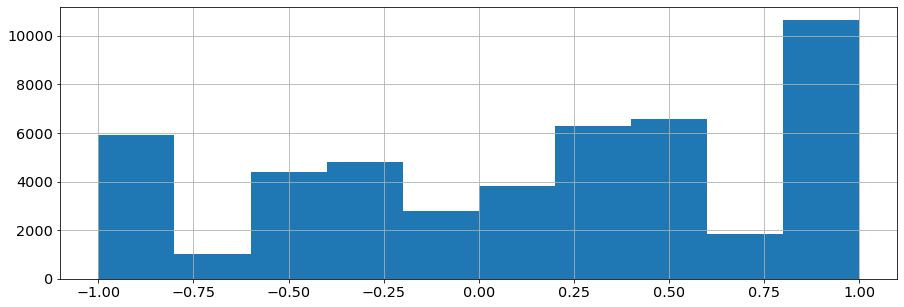

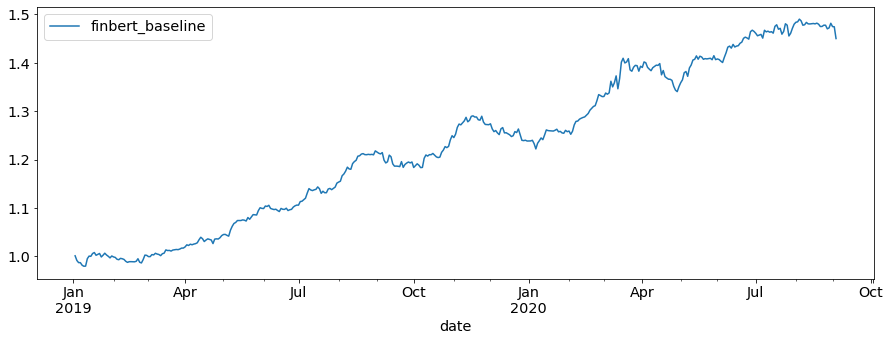

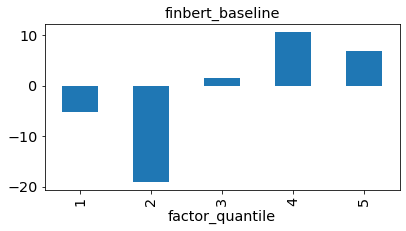

In [74]:
volatile_scores = scores_with_factors[scores_with_factors.Volatility_style>0][['dict_score',	'bert_baseline',	'finbert_baseline']]
score_analysis = volatile_scores['finbert_baseline'].dropna()[volatile_scores.finbert_baseline!=0]['2019-01-02':]
score_analysis.hist()
returns_finbert_highvol_tom = print_stats(score_analysis, shift=0, periods=1, bins=5)
#print_stats(score_analysis, shift=1, periods=1, bins=5)
#sharpes_finbert_small = []
#for sh in [3, 2, 1,0,-1,-2,-3,-4]:
#  sharpes_finbert_small.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Sharpe ratio:  2.8684040933715758


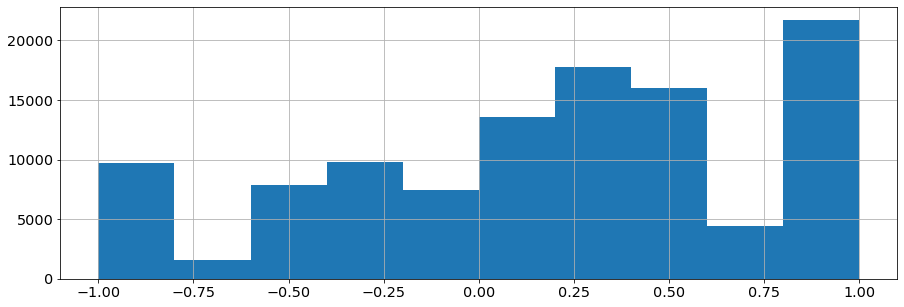

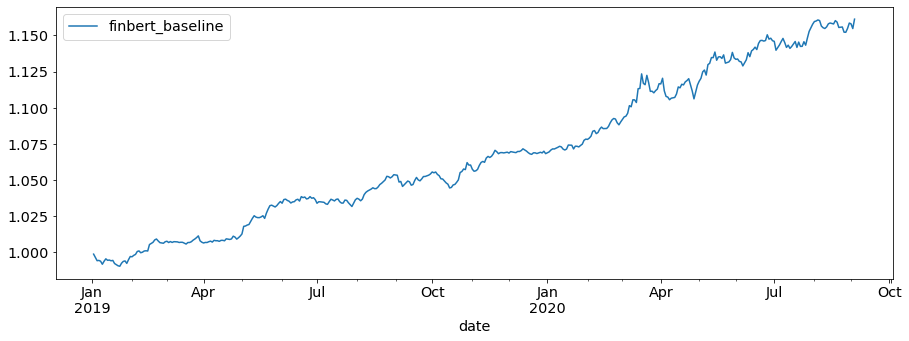

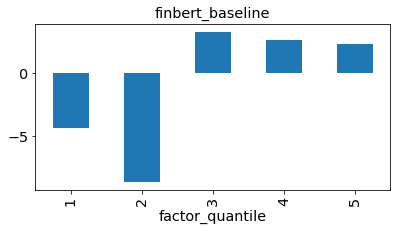

In [76]:
volatile_scores = scores_with_factors[scores_with_factors.Volatility_style<0][['dict_score',	'bert_baseline',	'finbert_baseline']]
score_analysis = volatile_scores['finbert_baseline'].dropna()[volatile_scores.finbert_baseline!=0]['2019-01-02':]
score_analysis.hist()
returns_finbert_lowvol_tom = print_stats(score_analysis, shift=0, periods=1, bins=5)
#print_stats(score_analysis, shift=1, periods=1, bins=5)
#sharpes_finbert_small = []
#for sh in [3, 2, 1,0,-1,-2,-3,-4]:
#  sharpes_finbert_small.append(get_sharpe(score_analysis, shift=sh, periods=1, bins=5))

Text(0, 0.5, 'Return')

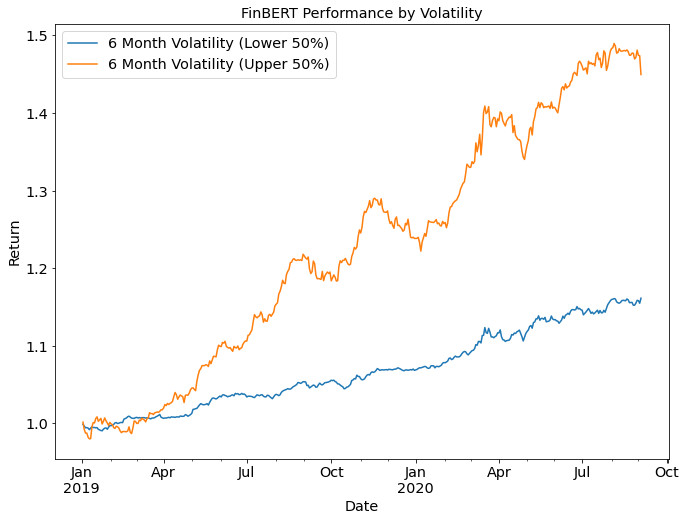

In [79]:
ret_plot_pd = pd.DataFrame(index = returns_tom_finbert.index)

ret_plot_pd['6 Month Volatility (Lower 50%)'] = returns_finbert_lowvol_tom
ret_plot_pd['6 Month Volatility (Upper 50%)'] = returns_finbert_highvol_tom

x = ret_plot_pd.plot(title='FinBERT Performance by Volatility',figsize=(11,8))
x.set_xlabel('Date')
x.set_ylabel('Return')

### Tearsheets

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.000000,-0.6,-0.946231,0.121696,18611,11.787843
2,-0.593750,-0.2,-0.374832,0.112531,26412,16.728844
3,-0.197802,0.2,0.042635,0.129086,27644,17.509168
4,0.202186,0.6,0.402588,0.105807,46560,29.490192
5,0.603774,1.0,0.945518,0.118683,38656,24.483953


Returns Analysis


,1D
Ann. alpha,0.163
beta,-0.070
Mean Period Wise Return Top Quantile (bps),4.322
Mean Period Wise Return Bottom Quantile (bps),-3.820
Mean Period Wise Spread (bps),8.142


<Figure size 1080x360 with 0 Axes>

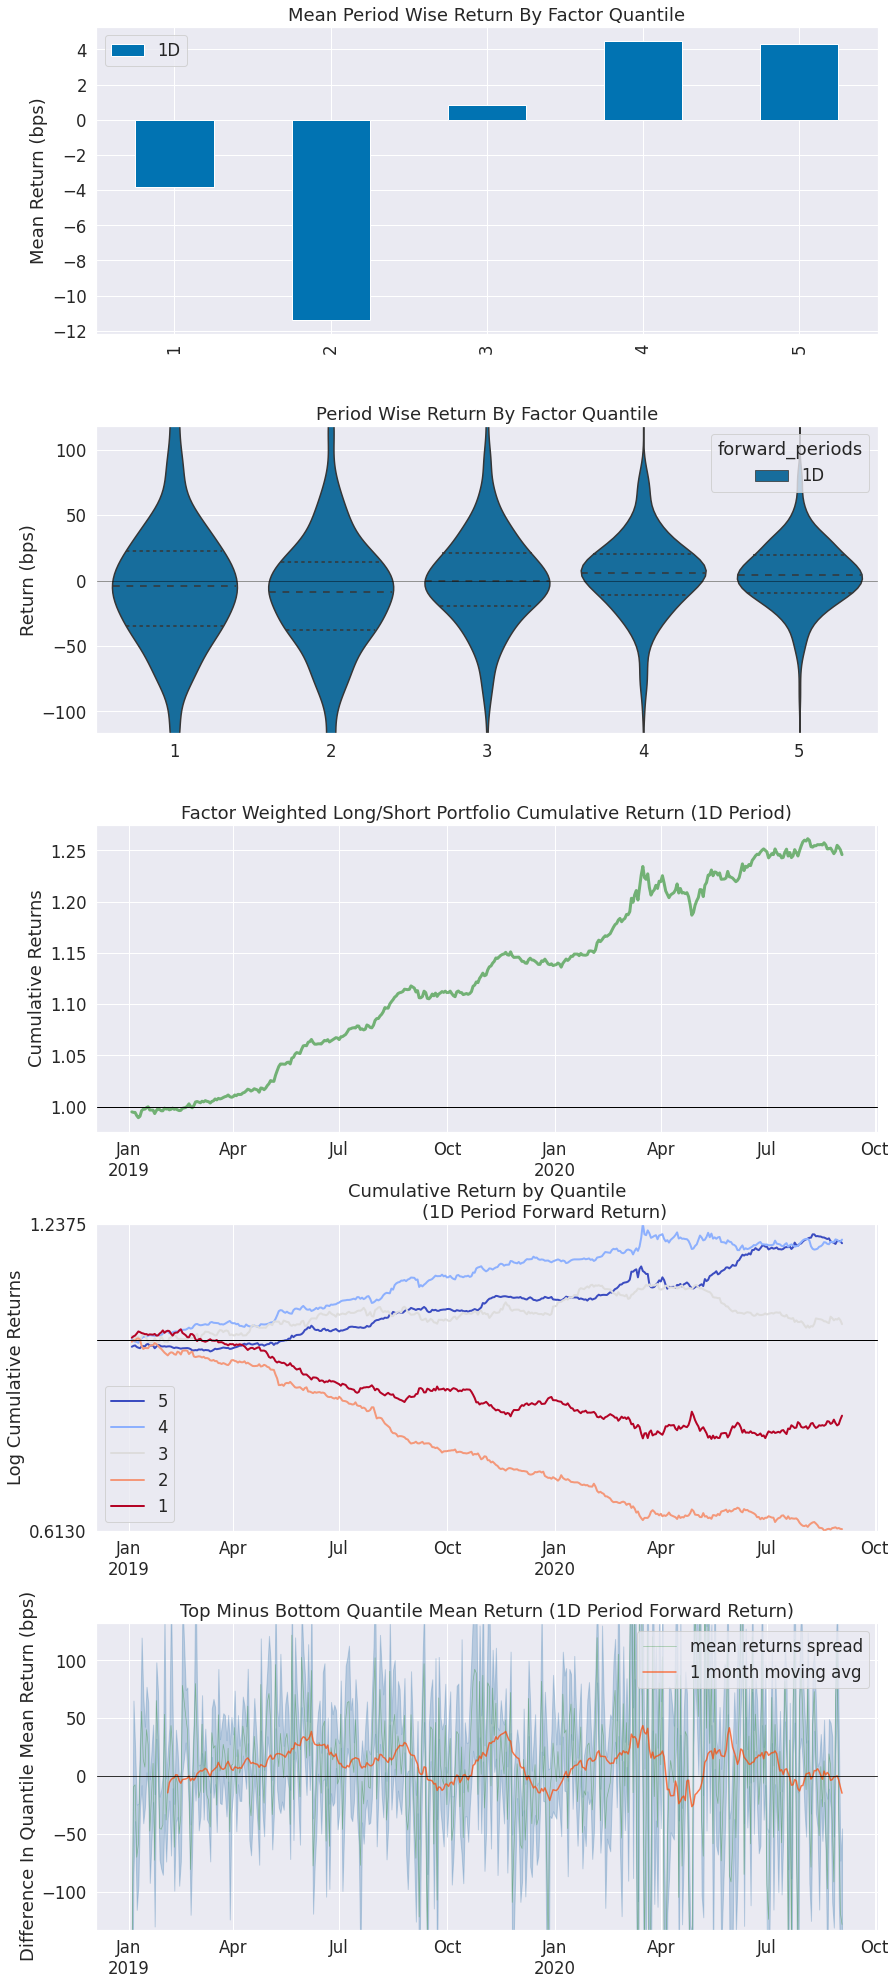

Information Analysis


,1D
IC Mean,0.012
IC Std.,0.074
Risk-Adjusted IC,0.166
t-stat(IC),3.404
p-value(IC),0.001
IC Skew,-0.126
IC Kurtosis,-0.411


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


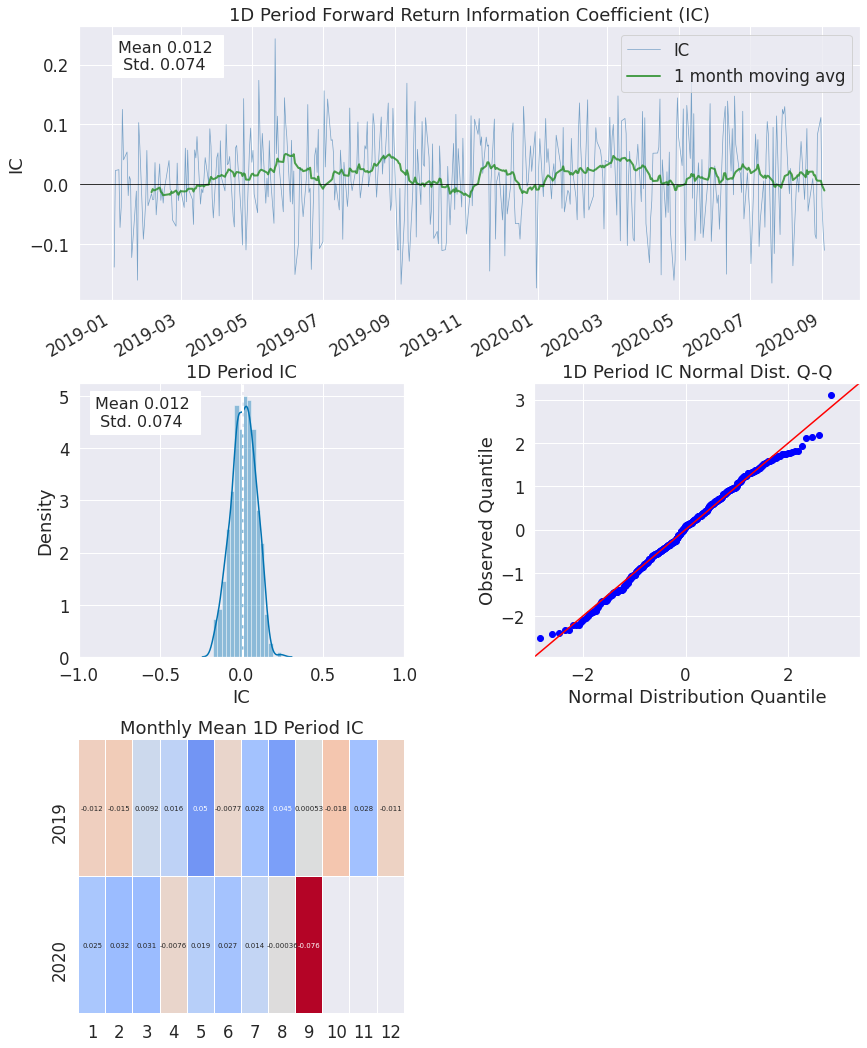

Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.940
Quantile 2 Mean Turnover,0.872
Quantile 3 Mean Turnover,0.618
Quantile 4 Mean Turnover,0.840
Quantile 5 Mean Turnover,0.907


,1D
Mean Factor Rank Autocorrelation,0.235


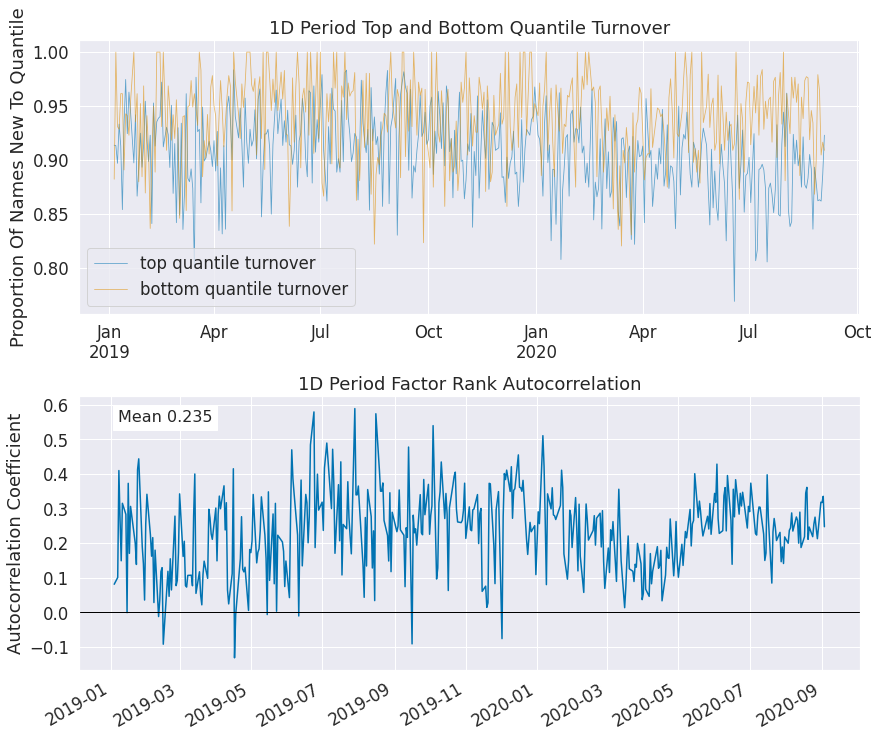

In [106]:
get_tearsheets(scores['finbert_baseline'][scores.finbert_baseline!=0]['2019-01-03':], bins=5)

In [ ]:
scores_with_factors[['Momentum_style','Reversal_style','Value_style','Volatility_style', 'dict_score',	'bert_baseline',	'finbert_baseline']])

In [ ]:
al.performance.factor_returns(scores_with_factors[['Momentum_style','Reversal_style','Value_style','Volatility_style', 'dict_score',	'bert_baseline',	'finbert_baseline']])

In [90]:
!pip3 install pyfolio

     |████████████████████████████████| 92kB 3.7MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88668 sha256=5d0d1a2066597fbc8b1eb3f24ab43a95f0a06de68308af25107bd071fe528d15
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
Successfully built pyfolio


In [91]:
import pyfolio as pf

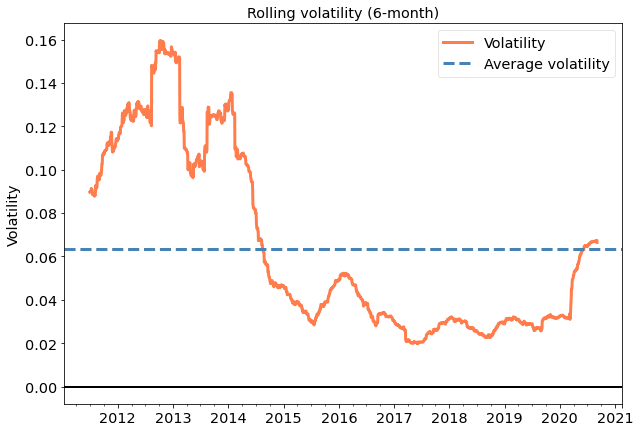

In [96]:
pf.plot_rolling_volatility(pyfolio_input['finbert_baseline'],figsize=(10,7))

Start date,2010-12-31
End date,2020-09-03
Total months,116
,Backtest
Annual return,14.5%
Cumulative returns,271.7%
Annual volatility,7.6%
Sharpe ratio,1.83
Calmar ratio,1.40
Stability,0.97
Max drawdown,-10.4%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.40,2012-08-31,2012-10-03,2012-12-20,80
1,9.18,2011-02-24,2011-05-27,2012-02-22,260
2,7.30,2013-07-25,2013-12-04,2013-12-20,107
3,4.50,2012-06-21,2012-07-11,2012-07-17,19
4,3.86,2014-02-14,2014-08-26,2014-10-30,185


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.05%,-1.54%,1.97%
Fukushima,-0.12%,-1.09%,0.51%
EZB IR Event,-0.24%,-2.82%,1.17%
Apr14,0.10%,-0.46%,1.10%
Oct14,0.10%,-0.50%,0.73%
Fall2015,0.08%,-0.46%,0.89%
Recovery,0.06%,-2.82%,6.24%
New Normal,0.05%,-4.45%,2.96%


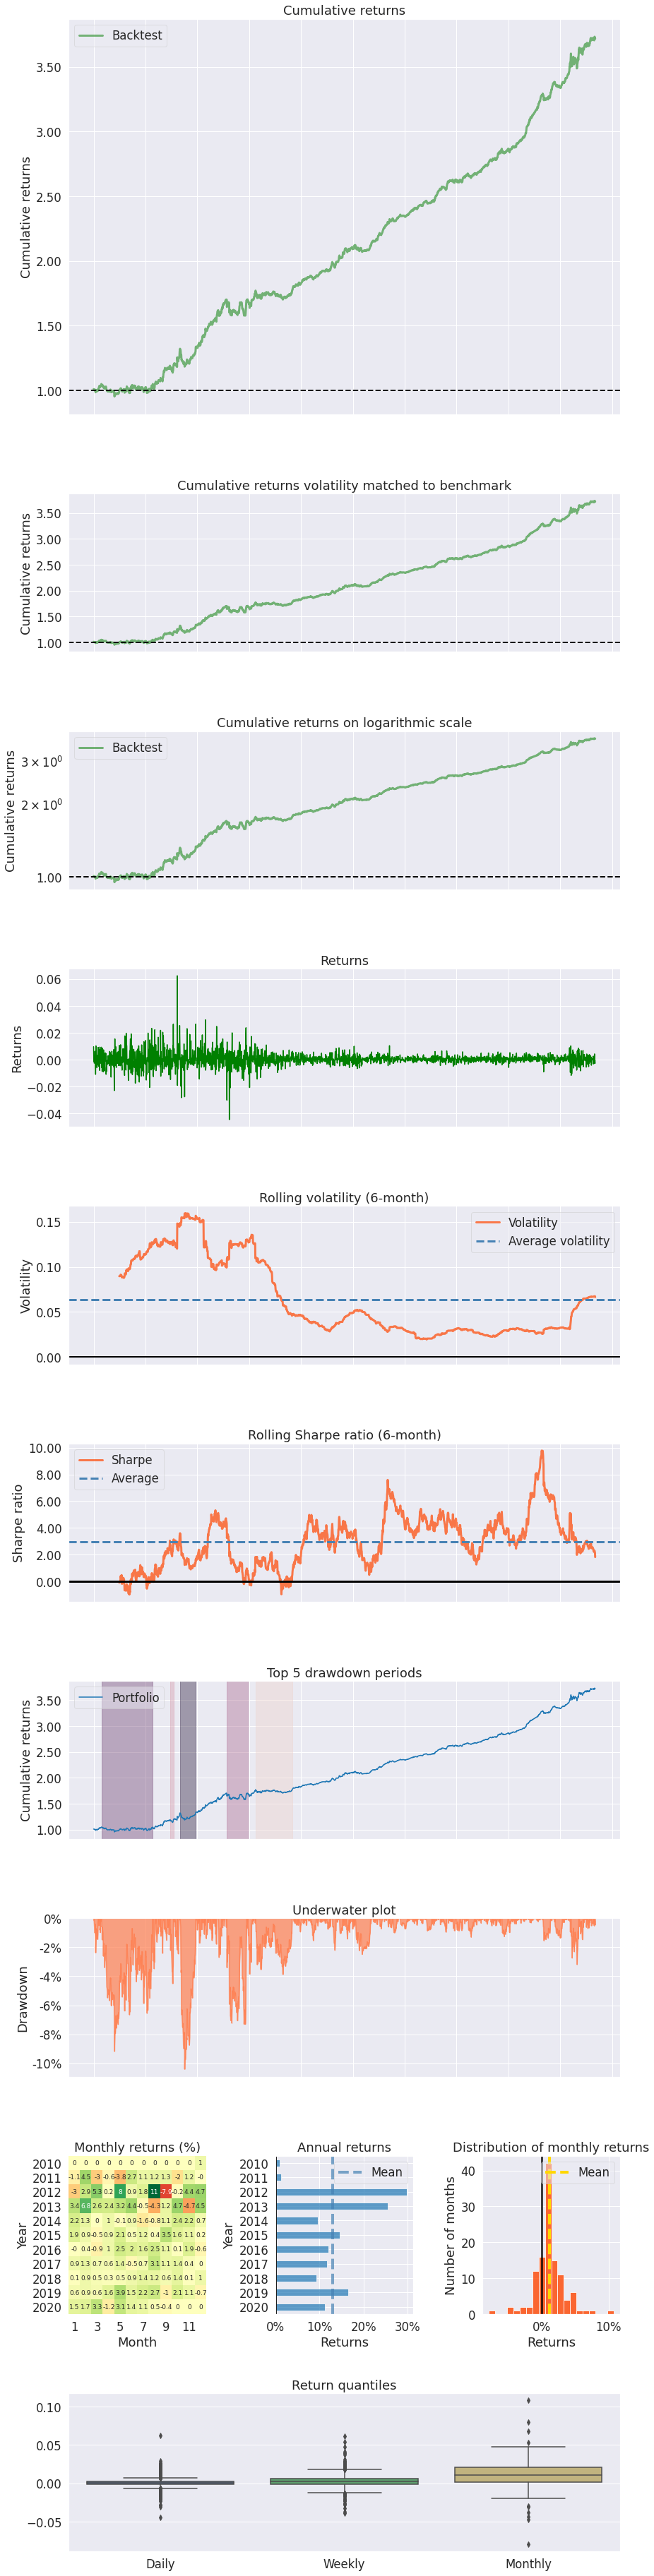

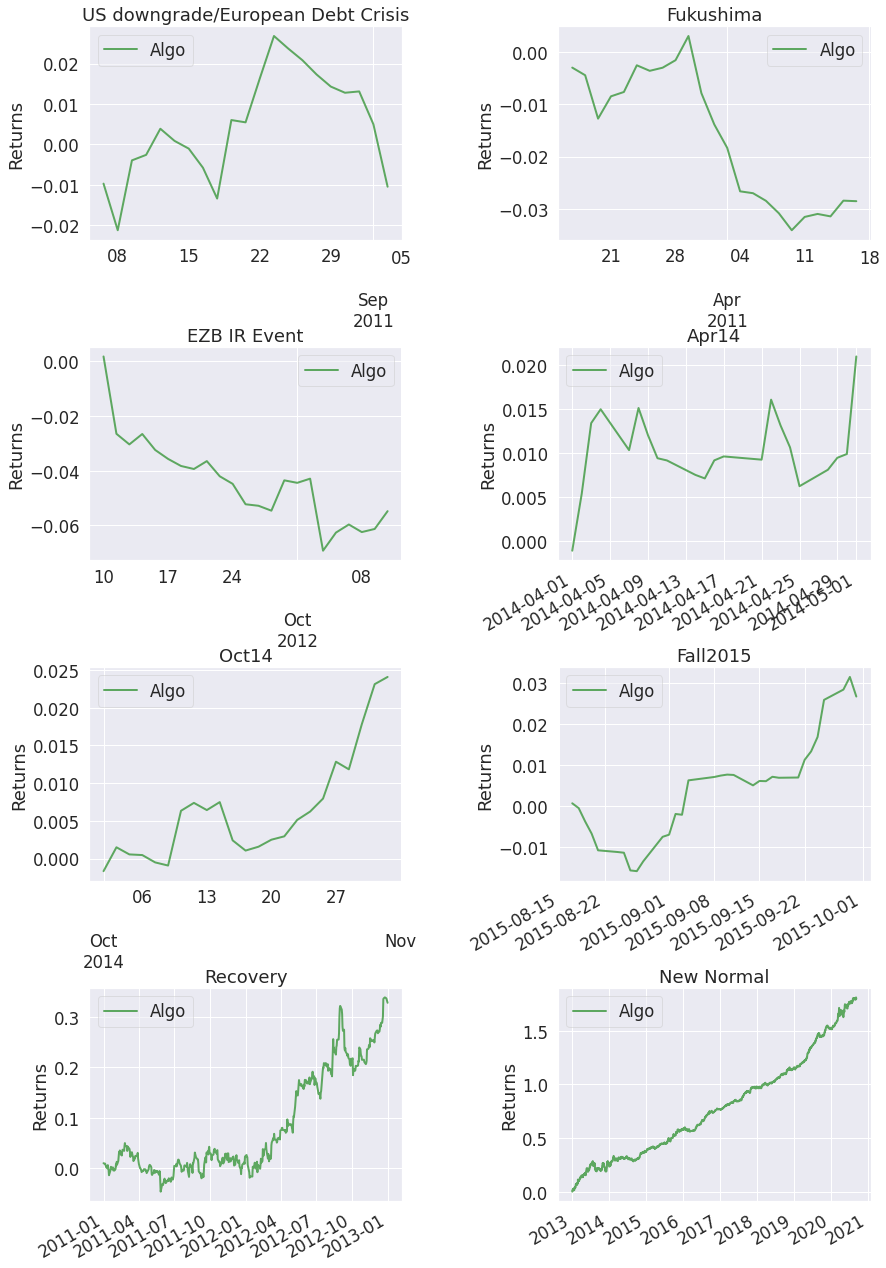

In [92]:
x = pf.create_full_tear_sheet(pyfolio_input['finbert_baseline'])

### Factor analysis

In [ ]:
scores_with_factors[['Momentum_style','Reversal_style','Value_style','Volatility_style', 'Size_style', 'dict_score',	'bert_baseline',	'finbert_baseline']]

Momentum_style  Reversal_style  \
date                      asset                                                 
2010-12-30 00:00:00+00:00 Equity(78 [ALL])          -0.564822       -1.166727   
                          Equity(105 [AMTD])        -0.897249       -0.014766   
                          Equity(106 [AMZN])         0.232869       -0.336335   
                          Equity(213 [BCH])          1.503138        0.765058   
                          Equity(342 [CCJ])         -0.117461       -1.096305   
                          Equity(543 [DIS])         -0.168083       -0.402293   
                          Equity(626 [EPD])          0.483270       -0.004969   
                          Equity(949 [JBL])         -0.886242       -1.465045   
                          Equity(1176 [MT])         -1.328001       -0.542819   
                          Equity(1324 [OXY])        -0.276962       -1.877932   
                          Equity(1367 [PFE])        -0.751733       -0.910882   
                          Equity(1520 [RY])         -0.367707        0.696942   
                          Equity(1667 [SWKS])        1.791973       -0.441973   
                          Equity(1677 [T])          -0.410217       -0.576364   
                          Equity(1830 [VAR])         0.614650       -0.554727   
2010-12-31 00:00:00+00:00 Equity(62 [AIG])           0.534008       -0.994300   
                          Equity(105 [AMTD])        -0.812252       -0.182821   
                          Equity(106 [AMZN])         0.208110       -0.561606   
                          Equity(113 [ANF])          1.106680       -0.281469   
                          Equity(308 [C])            0.271781        0.312197   
                          Equity(318 [CAJ])         -0.173554       -1.351942   
                          Equity(496 [CVS])         -0.644834       -0.898194   
                          Equity(536 [DFS])          0.153929        1.255023   
                          Equity(952 [JCI])          0.587330        0.388030   
                          Equity(1079 [LVS])         5.673854        1.213992   
                          Equity(1171 [MSFT])       -0.929037       -0.456942   
                          Equity(1176 [MT])         -1.303854       -0.533714   
                          Equity(1262 [NUAN])       -0.231178        0.410695   
                          Equity(1281 [NYT])        -1.389674        0.664137   
2011-01-03 00:00:00+00:00 Equity(87 [ALXN])          1.000328       -0.934980   
...                                                       ...             ...   
2020-09-03 00:00:00+00:00 Equity(1635 [SSNC])        0.139413       -1.235242   
                          Equity(1653 [STX])        -0.221423       -1.220612   
                          Equity(1672 [SYK])        -0.229770       -1.109945   
                          Equity(1677 [T])          -0.212405        0.585565   
                          Equity(1710 [TFX])        -0.058315       -1.245985   
                          Equity(1736 [TM])         -0.119174        1.224125   
                          Equity(1737 [TME])         0.170344       -0.854959   
                          Equity(1739 [TMO])         0.315966       -1.040330   
                          Equity(1759 [TROW])        0.137240       -0.801046   
                          Equity(1765 [TSCO])        0.351454        0.085013   
                          Equity(1767 [TSLA])        5.338597       -1.242629   
                          Equity(1768 [TSM])         0.771249       -0.500219   
                          Equity(1777 [TTM])        -0.160450       -1.158107   
                          Equity(1785 [TWLO])        0.900624       -0.521825   
                          Equity(1788 [TWTR])       -0.264206       -1.942426   
                          Equity(1791 [TXN])        -0.012552       -1.674805   
                          Equity(1797 [UAL])        -0.691392        0.045954 

In [102]:
def get_pyfolio(data_df, factor_name, shift=0, periods=1, bins=2):

    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                              prices=pricing.shift(shift), 
                                                              periods=[periods], 
                                                              max_loss=0.96, bins=bins, 
                                                              quantiles=None)
        for factor, factor_data in pd.DataFrame(data_df).iteritems()}

    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

    return ls_factor_returns[factor_name], \
           data_df[factor_name], \
           ls_factor_returns[['Momentum_style','Reversal_style','Value_style','Volatility_style','Size_style']], \
           data_df[['Momentum_style','Reversal_style','Value_style','Volatility_style','Size_style']]



In [121]:
a,b,c,d = get_pyfolio(scores_with_factors[['Momentum_style','Reversal_style','Value_style','Volatility_style','Size_style', 'finbert_baseline']],'finbert_baseline',shift=0);

Dropped 1.6% entries from factor data: 1.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 96.0%, not exceeded: OK!
Dropped 0.1% en

In [122]:
model = sm.OLS(a,sm.add_constant(c))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       finbert_baseline   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     33.31
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           5.50e-33
Time:                        08:08:52   Log-Likelihood:                 9999.7
No. Observations:                2436   AIC:                        -1.999e+04
Df Residuals:                    2430   BIC:                        -1.995e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0005   8.11e-05      5.937      0.000       0.000       0.001
Momentum_style       0.0815      0.012      6.834      0.000       0.058       0.105
Reversal_style      -0.0830      0.017     -4.821      0.000      -0.117      -0.049
Value_style         -0.0012      0.012     -0.100      0.921      -0.025       0.022
Volatility_style    -0.0790      0.015     -5.377      0.000      -0.108      -0.050
Size_style          -0.0446      0.028     -1.582      0.114      -0.100       0.011
==============================================================================
Omnibus:                     1190.314   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           130131.370
Skew:                           1.335   Prob(JB):                         0.00
Kurtosis:                      38.706   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
b = b.reset_index()

e = b.pivot_table(values='dict_score', index='date', columns='asset', aggfunc='first') 


In [ ]:
e['cash'] = np.nan